In [5]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import re
import spacy
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

In [8]:
class PatentAnalyzer:
    def __init__(self):
        self.categories = {
            'Детекторы нейтронов и частиц': [
                'нейтронный', 'детектор', 'газонаполненный', 'полупроводниковый', 
                'тепловых', 'холодных', 'быстрых', 'спектрометр', 'координатный',
                'позиционно', 'излучения', 'сцинтилляционный', 'счетчик', 'частиц',
                'ионизационный', 'регистрация', 'измерение'
            ],
            'Ускорители частиц и системы фокусировки': [
                'ускоритель', 'пучок', 'частиц', 'заряженных', 'циклический',
                'циклотрон', 'инжекция', 'фокусировки', 'ондулятор', 'накопитель',
                'ускорение', 'ионов', 'электронов', 'протонов', 'магнитный'
            ],
            'Измерительные системы и диагностика': [
                'измерения', 'измерение', 'угла', 'наклона', 'плоскости', 'импульса',
                'спектра', 'диагностика', 'мониторинг', 'анализа', 'распределения',
                'плотности', 'мощности', 'тока', 'напряжения', 'калибровка'
            ],
            'Сверхпроводимость и магнитные системы': [
                'сверхпроводящий', 'кабель', 'резонатор', 'магнитный', 'соленоид',
                'диод', 'разрядник', 'стабилизатор', 'преобразователь', 'высокотемпературный',
                'криостат', 'охлаждения', 'магнит', 'катушка'
            ],
            'Системы детектирования и анализа материалов': [
                'обнаружения', 'идентификации', 'скрытых', 'веществ', 'опасных',
                'радиоактивных', 'материалов', 'гетероэлектрик', 'урана', 'нанослоя',
                'поверхности', 'вакууме', 'анализ', 'контроля', 'диагностика'
            ],
            'Мембранные и фильтрующие технологии': [
                'мембран', 'трековых', 'полипропиленовых', 'субмикронных', 'фильтр',
                'мембрана', 'изготовления', 'пористый', 'фильтрация', 'сепарация'
            ],
            'Ядерные технологии и изотопы': [
                'изотоп', 'радиоизотоп', 'изотопа', 'радиоизотопов', 'носителя',
                'препарата', 'фармпрепарат', 'радиофармацевтический', 'мишень',
                'облучение', 'радиосинтез', 'ядерный', 'деление', 'реактор',
                'топливо', 'уран', 'плутоний', 'радиационный', 'активация'
            ],
            'Медицинское оборудование и биотехнологии': [
                'криохирургический', 'аппарат', 'терапия', 'медицинский', 'лечение',
                'диагностика', 'опухоль', 'биологический', 'клетка', 'спирулина',
                'биоматериал', 'имплантат', 'протез', 'хирургический'
            ],
            'Вакуумные и криогенные системы': [
                'вакуумный', 'вакууме', 'криогенный', 'охлаждения', 'криостат',
                'холодильный', 'температура', 'криосорбционный', 'насос', 'компрессор'
            ],
            'Оптические и лазерные системы': [
                'оптический', 'лазер', 'излучения', 'фотоэлемент', 'ондулятор',
                'свет', 'линза', 'зеркало', 'фотон', 'интерферометр', 'дифракция'
            ],
            'Электронные системы и источники питания': [
                'источник', 'питания', 'стабилизатор', 'преобразователь', 'транзистор',
                'диод', 'микросхема', 'процессор', 'контроллер', 'регулятор'
            ]
        }
        
        self.category_mapping = {}
    
    def load_data(self, file_path):
        if file_path.endswith('.json'):
            with open(file_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
            df = pd.DataFrame(data)
        else:
            df = pd.read_csv(file_path, sep=';', encoding='utf-8-sig')
        
        df['date'] = pd.to_datetime(df['дата'], format='%d.%m.%Y', errors='coerce')
        df['year'] = df['date'].dt.year
        df = df.dropna(subset=['название', 'year'])
        df['year'] = df['year'].astype(int)
        
        df['cleaned_name'] = df['название'].apply(self.clean_text)
        
        return df
    
    def clean_text(self, text):
        if not isinstance(text, str):
            return ""
        
        text = re.sub(r'\s+', ' ', text)
        text = text.lower().strip()
        words = [word for word in text.split() 
                if len(word) > 2]
        return ' '.join(words)
    
    def assign_to_categories(self, df):
        result_df = df.copy()
        result_df['category'] = None
        
        for idx, row in result_df.iterrows():
            title = row['cleaned_name']
            best_category = None
            best_match_count = 0
            
            for category, keywords in self.categories.items():
                match_count = 0
                for keyword in keywords:
                    if keyword in title:
                        match_count += 1
                
                if match_count > best_match_count:
                    best_match_count = match_count
                    best_category = category
            
            if best_match_count >= 2:
                result_df.at[idx, 'category'] = best_category
        
        return result_df
    
    def get_uncategorized_patents(self, df):
        uncategorized = df[df['category'].isna()].copy()
        return uncategorized
    
    def find_optimal_clusters(self, tfidf_matrix, max_k=15):
        silhouette_scores = []
        k_range = range(2, min(max_k + 1, tfidf_matrix.shape[0]))
        
        for k in k_range:
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            labels = kmeans.fit_predict(tfidf_matrix)
            if len(set(labels)) > 1:
                score = silhouette_score(tfidf_matrix, labels)
                silhouette_scores.append(score)
            else:
                silhouette_scores.append(0)
        
        optimal_k = k_range[np.argmax(silhouette_scores)]
        return optimal_k, silhouette_scores
    
    def extract_cluster_keywords(self, tfidf_matrix, vectorizer, labels, n_keywords=15):
        cluster_keywords = {}
        feature_names = vectorizer.get_feature_names_out()
        
        for cluster_id in np.unique(labels):
            cluster_indices = np.where(labels == cluster_id)[0]
            
            if len(cluster_indices) == 0:
                continue
                
            cluster_tfidf = tfidf_matrix[cluster_indices].mean(axis=0)
            cluster_tfidf = np.array(cluster_tfidf).flatten()
            
            top_indices = cluster_tfidf.argsort()[-n_keywords:][::-1]
            keywords = [feature_names[i] for i in top_indices if cluster_tfidf[i] > 0]
            
            cluster_keywords[cluster_id] = keywords
        
        return cluster_keywords
    
    def reassign_clusters_to_categories(self, cluster_keywords):
        cluster_categories = {}
        category_scores = {}
        category_details = {}
        
        for cluster_id, keywords in cluster_keywords.items():
            best_category = None
            best_score = 0
            best_matches = []
            
            for category, category_terms in self.categories.items():
                score = 0
                matches = []
                
                for keyword in keywords[:15]:
                    for cat_term in category_terms:
                        if cat_term == keyword:
                            score += 3
                            matches.append(f"{keyword}✓")
                        elif cat_term in keyword and len(cat_term) > 4:
                            score += 2
                            matches.append(f"{keyword}→{cat_term}")
                        elif keyword in cat_term and len(keyword) > 4:
                            score += 1
                            matches.append(f"{keyword}←{cat_term}")
                
                if score > best_score:
                    best_score = score
                    best_category = category
                    best_matches = matches[:5]
            
            if best_score >= 4:
                cluster_categories[cluster_id] = best_category
                category_scores[cluster_id] = best_score
                category_details[cluster_id] = best_matches
            else:
                cluster_categories[cluster_id] = None
        
        return cluster_categories, category_scores, category_details
    
    def finalize_category_assignment(self, df, uncategorized, cluster_labels, cluster_categories):
        final_df = df.copy()
        
        uncategorized_idx = uncategorized.index.tolist()
        for i, idx in enumerate(uncategorized_idx):
            cluster_id = cluster_labels[i]
            category = cluster_categories.get(cluster_id)
            
            if category:
                final_df.at[idx, 'category'] = category
        
        return final_df
    
    def create_patent_landscape(self, file_path):
        df = self.load_data(file_path)
        
        df = self.assign_to_categories(df)
        
        uncategorized = self.get_uncategorized_patents(df)
        
        if len(uncategorized) == 0:
            return df, {}, {}
        
        vectorizer = TfidfVectorizer(
            max_features=1000,
            min_df=2,
            max_df=0.8,
            ngram_range=(1, 2)
        )
        
        tfidf_matrix = vectorizer.fit_transform(uncategorized['cleaned_name'])
        
        optimal_k, silhouette_scores = self.find_optimal_clusters(tfidf_matrix)
        
        kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=40)
        cluster_labels = kmeans.fit_predict(tfidf_matrix)
        
        cluster_keywords = self.extract_cluster_keywords(tfidf_matrix, vectorizer, cluster_labels)
        
        self.print_cluster_keywords(cluster_keywords)
        
        cluster_categories, category_scores, category_details = self.reassign_clusters_to_categories(cluster_keywords)
        
        final_df = self.finalize_category_assignment(df, uncategorized, cluster_labels, cluster_categories)
        
        self.print_analysis_results(final_df, cluster_keywords, cluster_categories, category_scores, category_details)
        
        self.create_visualizations(final_df)
        
        return final_df, cluster_keywords, cluster_categories
    
    def print_cluster_keywords(self, cluster_keywords):
        print("\n" + "="*80)
        print("КЛЮЧЕВЫЕ СЛОВА КЛАСТЕРОВ")
        print("="*80)
        
        for cluster_id in sorted(cluster_keywords.keys()):
            keywords = cluster_keywords[cluster_id]
            print(f"\n--- Кластер {cluster_id} ---")
            print(f"Топ-15 ключевых слов: {', '.join(keywords)}")
    
    def print_analysis_results(self, df, cluster_keywords, cluster_categories, category_scores, category_details):

        print("РЕЗУЛЬТАТЫ АНАЛИЗА ПАТЕНТНОГО ЛАНДШАФТА")
   
        category_dist = df['category'].value_counts()
        total_patents = len(df)
        
        print(f"\nРАСПРЕДЕЛЕНИЕ ПО КАТЕГОРИЯМ (всего патентов: {total_patents}):")
        for category, count in category_dist.items():
            percentage = (count / total_patents) * 100
            print(f"  {category}: {count} патентов ({percentage:.1f}%)")
        
        initial_categorized = df['category'].notna().sum() - len([c for c in cluster_categories.values() if c is not None])
        print(f"\nНазначено на первом этапе: {initial_categorized} патентов")
        print(f"Назначено через кластеризацию: {len([c for c in cluster_categories.values() if c is not None])} патентов")
        print(f"Осталось некатегоризированных: {len(df) - df['category'].notna().sum()} патентов")
    
    def create_visualizations(self, df):
        plt.style.use('default')
        
        plt.figure(figsize=(14, 8))
        category_counts = df['category'].value_counts()
        
        colors = plt.cm.Set3(np.linspace(0, 1, len(category_counts)))
        bars = plt.bar(range(len(category_counts)), category_counts.values, color=colors)
        
        plt.title('Распределение патентов по categoryм', fontsize=16, pad=20)
        plt.xlabel('Категории', fontsize=12)
        plt.ylabel('Количество патентов', fontsize=12)
        plt.xticks(range(len(category_counts)), category_counts.index, rotation=45, ha='right')
        
        for bar, count in zip(bars, category_counts.values):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                    f'{count}', ha='center', va='bottom')
        
        plt.tight_layout()
        plt.show()
        
        plt.figure(figsize=(14, 12))
        
        threshold = 0.02
        total = len(df)
        main_categories = category_counts[category_counts / total >= threshold]
        other_count = category_counts[category_counts / total < threshold].sum()
        
        if other_count > 0:
            main_categories['others'] = other_count
        
        colors = plt.cm.Pastel1(np.linspace(0, 1, len(main_categories)))
        
        wedges, texts, autotexts = plt.pie(main_categories.values, 
                                        labels=None,
                                        autopct='%1.1f%%',
                                        startangle=90,
                                        colors=colors,
                                        shadow=True,
                                        pctdistance=0.85,
                                        labeldistance=1.05)
        
        for autotext in autotexts:
            autotext.set_color('darkblue')
            autotext.set_fontweight('bold')
            autotext.set_fontsize(10)
        
        plt.legend(wedges, 
                [f'{label}: {count} ({count/total:.1%})' 
                for label, count in main_categories.items()],
                title="Категории",
                loc="center left",
                bbox_to_anchor=(1, 0, 0.5, 1),
                fontsize=11)
        
        plt.title('Распределение патентов по categoryм\n(круговая диаграмма)', 
                fontsize=16, pad=20, fontweight='bold')
        plt.axis('equal')
        plt.tight_layout()
        plt.show()
        
        plt.figure(figsize=(15, 9))
        
        yearly_data = df.groupby(['year', 'category']).size().unstack(fill_value=0)
        
        yearly_data.to_csv('time_series_clusters.csv', encoding='utf-8-sig')
        print("Временной ряд для кластеров экспортирован в 'time_series_clusters.csv'")
        
        for category in yearly_data.columns:
            plt.plot(yearly_data.index, yearly_data[category], 
                    marker='o', linewidth=2.5, markersize=5, label=category)
        
        plt.title('Динамика патентования по categoryм', fontsize=18, pad=20)
        plt.xlabel('year', fontsize=14)
        plt.ylabel('Количество патентов', fontsize=14)
        
        plt.legend(title='category', loc='best', fontsize=10, 
                title_fontsize=12, framealpha=0.9)
        
        plt.grid(True, alpha=0.3, linestyle='--')
        plt.xlim(yearly_data.index.min() - 1, yearly_data.index.max() + 1)
        
        plt.tick_params(axis='both', which='major', labelsize=11)
        
        plt.tight_layout(pad=2.0)
        plt.show()


КЛЮЧЕВЫЕ СЛОВА КЛАСТЕРОВ

--- Кластер 0 ---
Топ-15 ключевых слов: способ, способ получения, получения, пучка, формирования, радиоактивных, способ измерения, энергии, излучения, инжекции, способ формирования, измерения, ионов, заболеваний, способ инжекции

--- Кластер 1 ---
Топ-15 ключевых слов: биологических, устройство для, устройство, для радиационной, радиационной, защиты биологических, радиационной защиты, объектов, объектов эксперименте, биологических объектов, охлаждения, для, защиты, эксперименте

--- Кластер 2 ---
Топ-15 ключевых слов: шариков, холодного, замедлителя нейтронов, замедлителя, холодного замедлителя, нейтронов, шарикового холодного, шарикового, регистрации, для, детектирования, для детектирования, твердых, способ, устройство для

--- Кластер 3 ---
Топ-15 ключевых слов: диод, для, терапии, гетероэлектрик, фотоэлемент, ондулятор, система, взрывоэмиссионный, катод, конденсатор, сцинтиллятор, лучевой, типа, твердотельный, детектор

--- Кластер 4 ---
Топ-15 ключевых сл

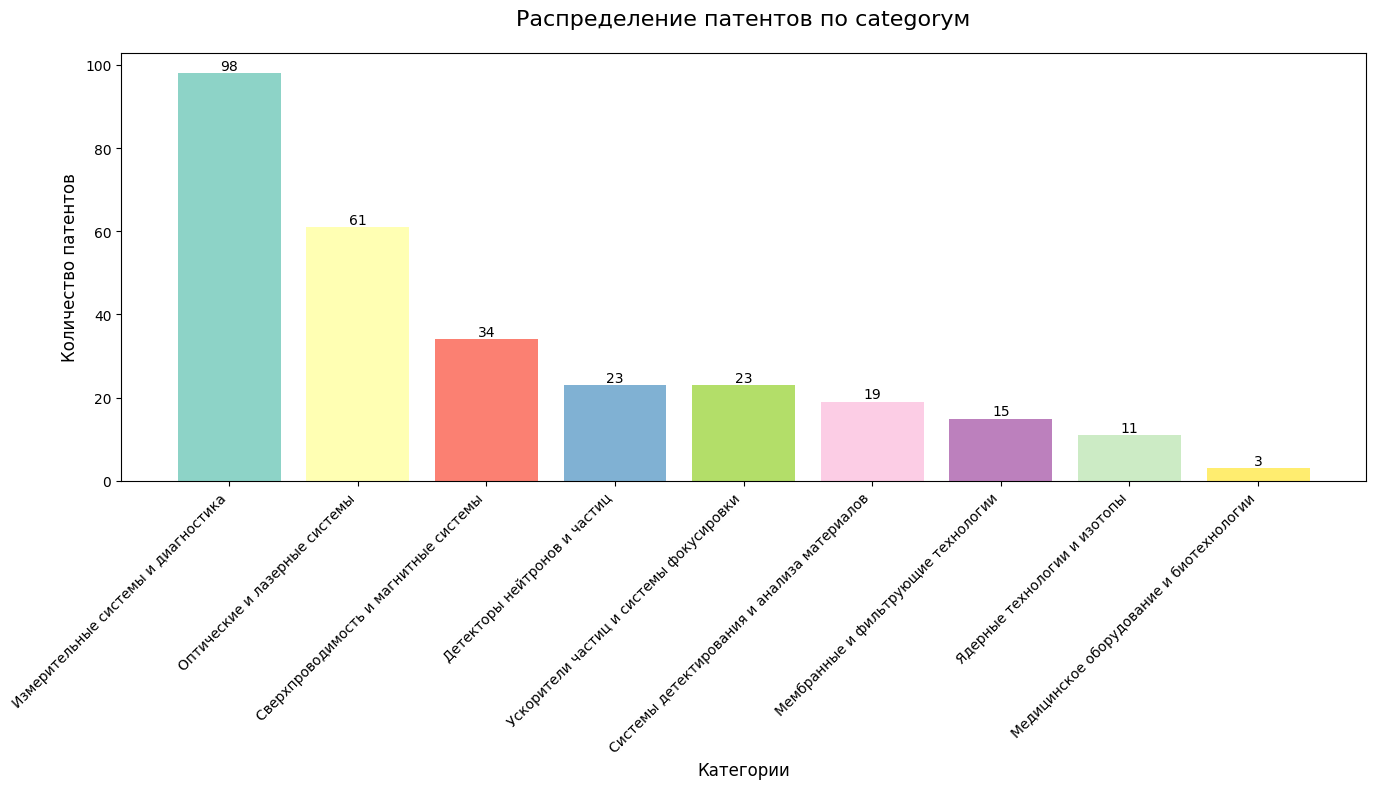

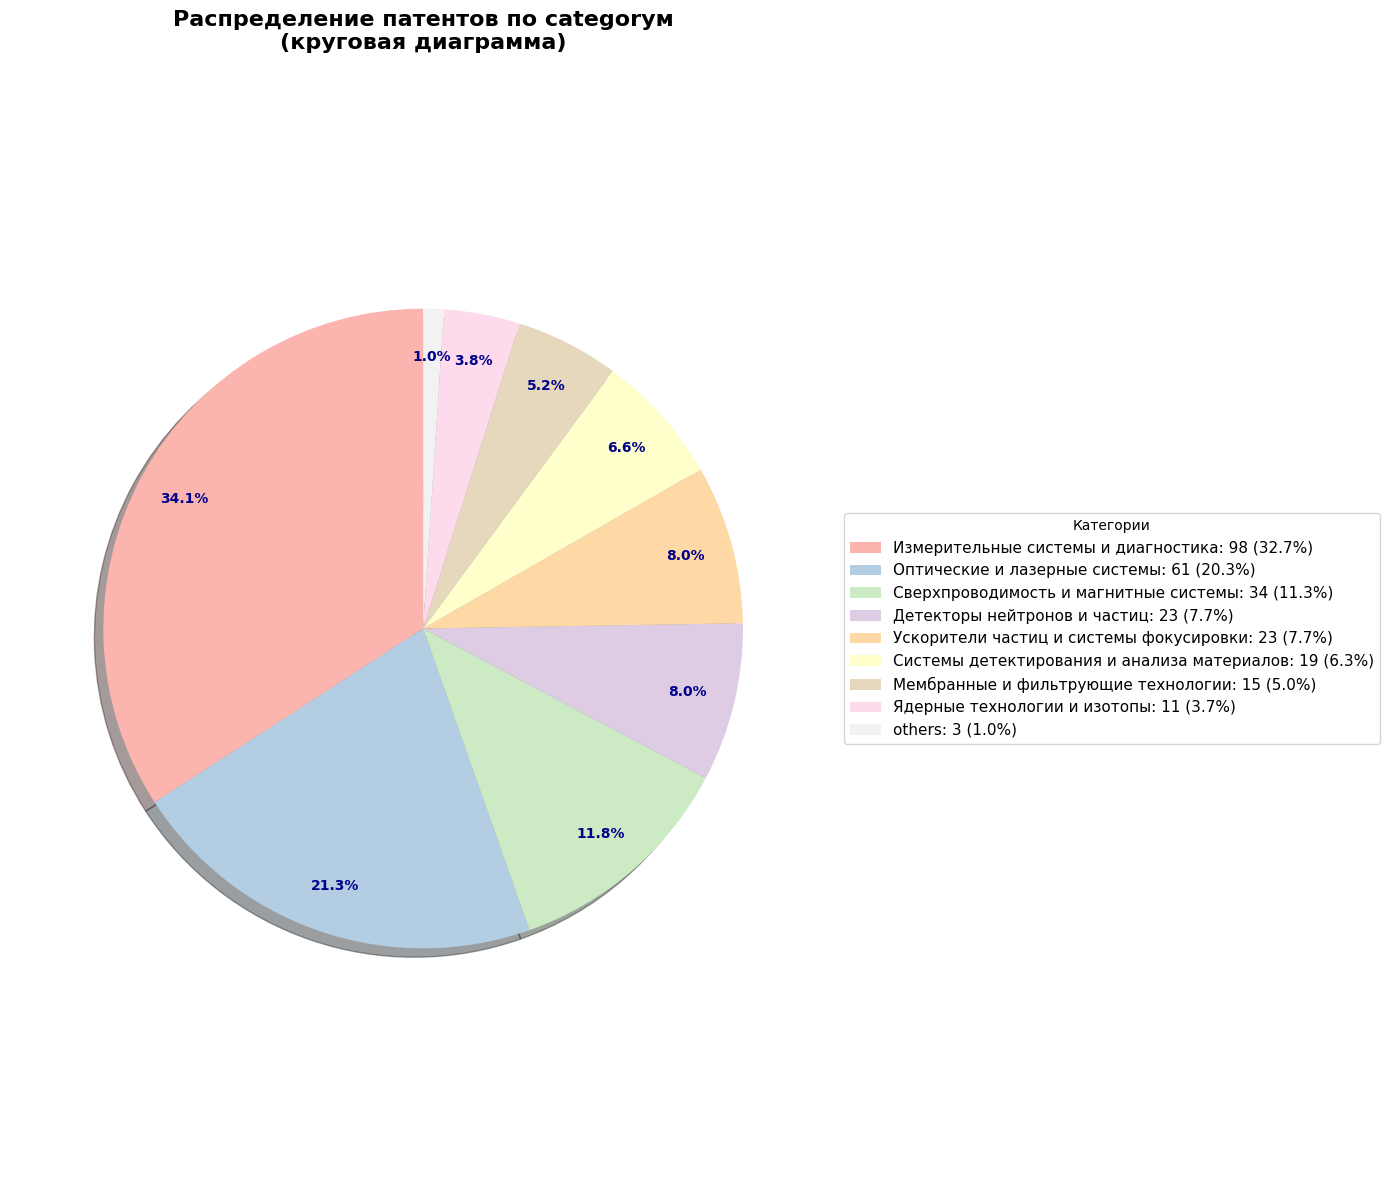

Временной ряд для кластеров экспортирован в 'time_series_clusters.csv'


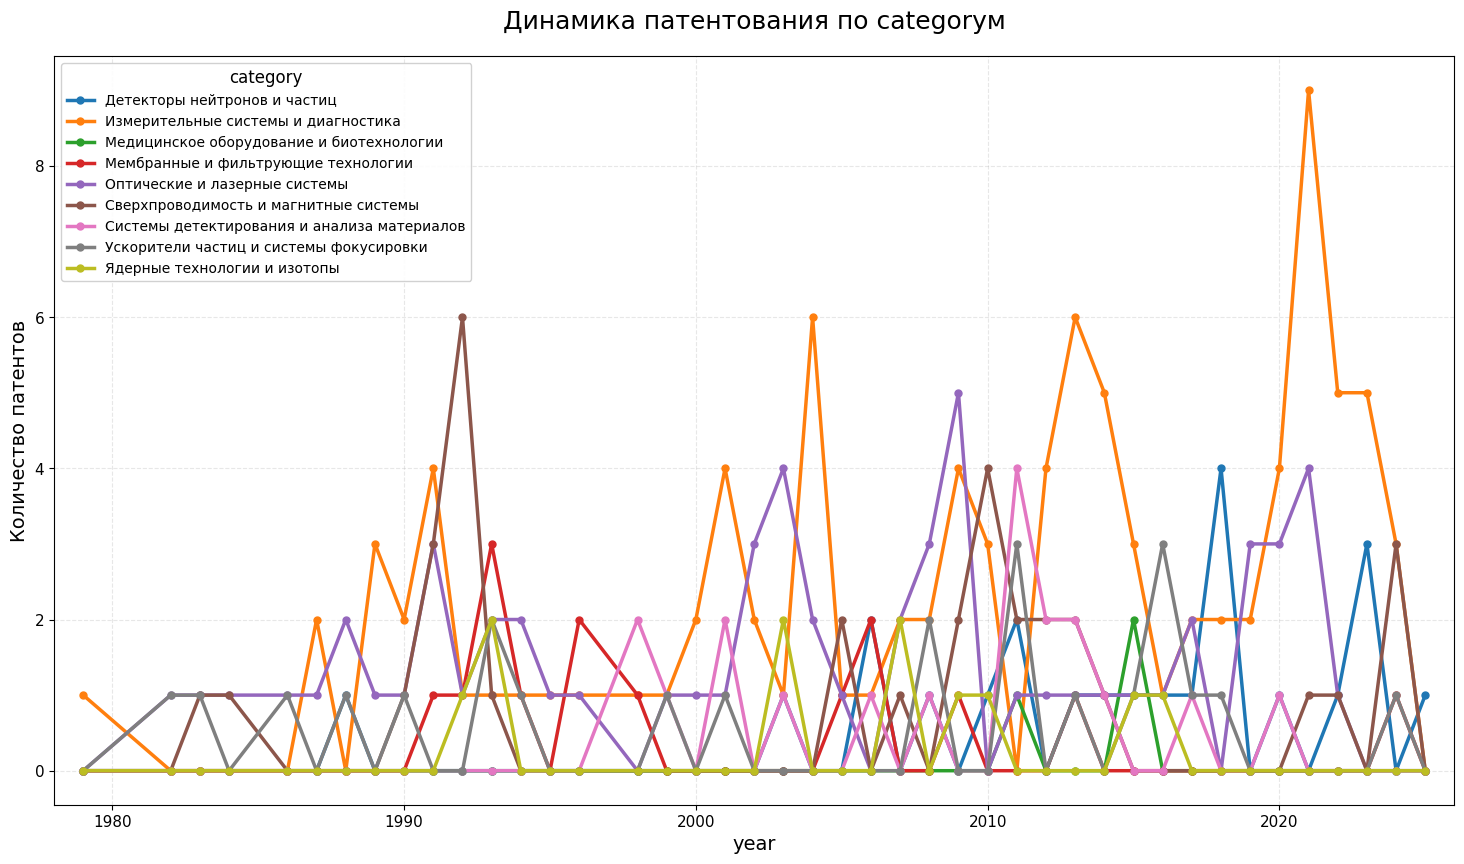


Результаты сохранены в 'patent_analysis.csv'

Кластер 0 [Измерительные системы и диагностика]:
  способ, способ получения, получения, пучка, формирования, радиоактивных, способ измерения, энергии, излучения, инжекции, способ формирования, измерения

Кластер 3 [Оптические и лазерные системы]:
  диод, для, терапии, гетероэлектрик, фотоэлемент, ондулятор, система, взрывоэмиссионный, катод, конденсатор, сцинтиллятор, лучевой

Кластер 4 [Ускорители частиц и системы фокусировки]:
  источник, источник электронов, ионный источник, ионный, электронов, взрывоэмиссионный, ионов

Кластер 5 [Сверхпроводимость и магнитные системы]:
  способ изготовления, изготовления, способ, соединения, материала, оптической, охлаждения, для, резонатора, пленки

Кластер 6 [Сверхпроводимость и магнитные системы]:
  ускорения, способ ускорения, способ, ускорения макрочастиц, макрочастиц, диполей, магнитных диполей, ускорения магнитных, магнитных

Кластер 7 [Сверхпроводимость и магнитные системы]:
  тока, постоянного

In [9]:
if __name__ == "__main__":
    analyzer = PatentAnalyzer()
    
    try:
        file_path = "parsed_data.json"
        
        df, cluster_keywords, cluster_categories = analyzer.create_patent_landscape(file_path)
        
        df.to_csv('patent_analysis.csv', index=False, encoding='utf-8-sig')
        print("\nРезультаты сохранены в 'patent_analysis.csv'")
        
        for cluster_id in sorted(cluster_keywords.keys()):
            cat = cluster_categories.get(cluster_id, "Не назначена")
            if cat is None:
                continue
            kws = cluster_keywords[cluster_id][:12]
            print(f"\nКластер {cluster_id} [{cat}]:")
            print(f"  {', '.join(kws)}")
        
    except Exception as e:
        print(f"Ошибка: {e}")